# Emotion Recognition through Voice Analysis using Deep Learning Techniques

#The problem you are trying to solve:
Emotion recognition from speech to improve human-computer interaction and user experience in various applications such as virtual assistants, customer service, and mental health monitoring.

#Why the problem is important to solve?
Emotion recognition can significantly improve the quality of interactions between humans and computers. By detecting emotions from speech, computer systems and applications can respond more appropriately to users' needs and preferences. This can enhance user experience in customer service, virtual assistants, and mental health applications, among others. Moreover, emotion recognition can help in identifying and tracking mental health issues, allowing for timely interventions and support.

#What is your idea to solve the problem?
The proposed approach is to use machine learning techniques, particularly deep learning models such as Convolutional Neural Networks (CNNs) and Long Short-Term Memory (LSTM) networks, to classify emotions from speech data. By training these models on a labeled dataset of speech samples, the models can learn to identify and classify emotions accurately. The input features for the models will be extracted using audio processing techniques, such as Mel-frequency cepstral coefficients (MFCCs), which capture the characteristics of the audio signals.

#What differences you could make with your data science approach?
By using a data-driven approach with deep learning models, the emotion recognition system can achieve higher accuracy in classifying emotions from speech compared to traditional rule-based or shallow learning techniques. This improvement in accuracy will result in more effective human-computer interactions, enhancing user experience in various applications. Additionally, the system can be continuously improved by training on more data and refining the models, ensuring that it stays up-to-date and effective in recognizing emotions across diverse populations and contexts.

# Data Collection:

In [ ]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD





In [ ]:
from google.colab import drive
drive.mount('/content/audio_speech_actors_01-24')


Mounted at /content/audio_speech_actors_01-24


In [ ]:
# Preparing data set
RAVD = "/content/audio_speech_actors_01-24/MyDrive/audio_speech_actors_01-24"

In [ ]:
print(RAVD)

/content/audio_speech_actors_01-24/MyDrive/audio_speech_actors_01-24


In [ ]:
import os
import pandas as pd

RAVD = "/content/audio_speech_actors_01-24/MyDrive/audio_speech_actors_01-24"

dirl_list = os.listdir(RAVD)
dirl_list.sort()

emotion = []
gender = []
path = []
for i in dirl_list:
    dir_path = os.path.join(RAVD, i)
    fname = os.listdir(dir_path)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp % 2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(os.path.join(dir_path, f))

RAVD_df = pd.DataFrame(emotion)
RAVD_df = RAVD_df.replace({1: 'neutral', 2: 'neutral', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'})
RAVD_df = pd.concat([pd.DataFrame(gender), RAVD_df], axis=1)
RAVD_df.columns = ['gender', 'emotion']
RAVD_df['labels'] = RAVD_df.gender + '_' + RAVD_df.emotion
RAVD_df['source'] = 'RAVDESS'
RAVD_df = pd.concat([RAVD_df, pd.DataFrame(path, columns=['path'])], axis=1)
RAVD_df = RAVD_df.drop(['gender', 'emotion'], axis=1)
RAVD_df.labels.value_counts()


male_neutral       144
female_neutral     144
male_angry          96
male_sad            96
male_happy          96
male_fear           96
male_surprise       96
male_disgust        96
female_sad          96
female_happy        96
female_angry        96
female_disgust      96
female_surprise     96
female_fear         96
Name: labels, dtype: int64

# Data Exploration: Exploring the Dataset



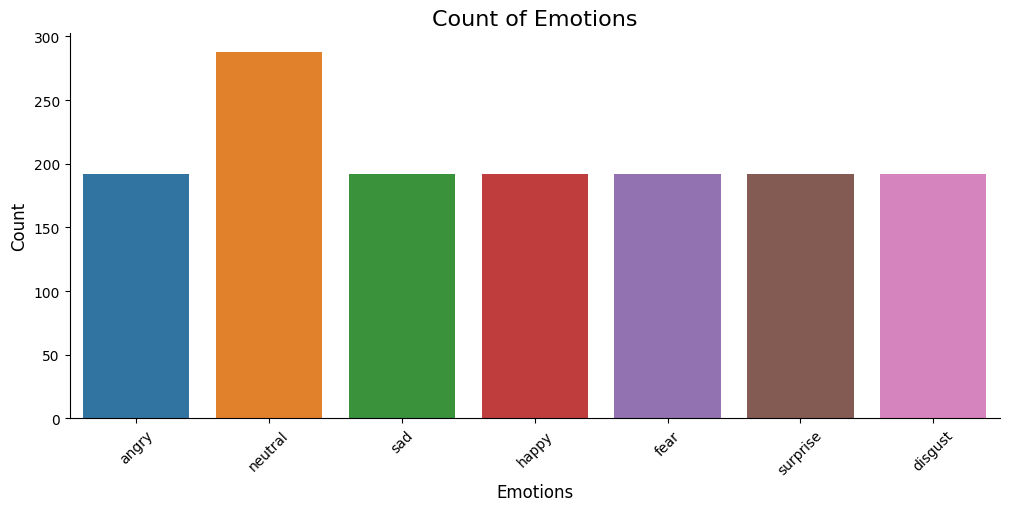

In [ ]:
import seaborn as sns

# Assuming RAVD_df is your dataframe
RAVD_df['emotions'] = RAVD_df['labels'].str.split('_', expand=True)[1]

# Create a new dataframe with only the 'emotions' column
emotions_df = pd.DataFrame(RAVD_df['emotions'])

plt.figure(figsize=(12, 5))
plt.title('Count of Emotions', size=16)
sns.countplot(data=emotions_df, x='emotions')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()





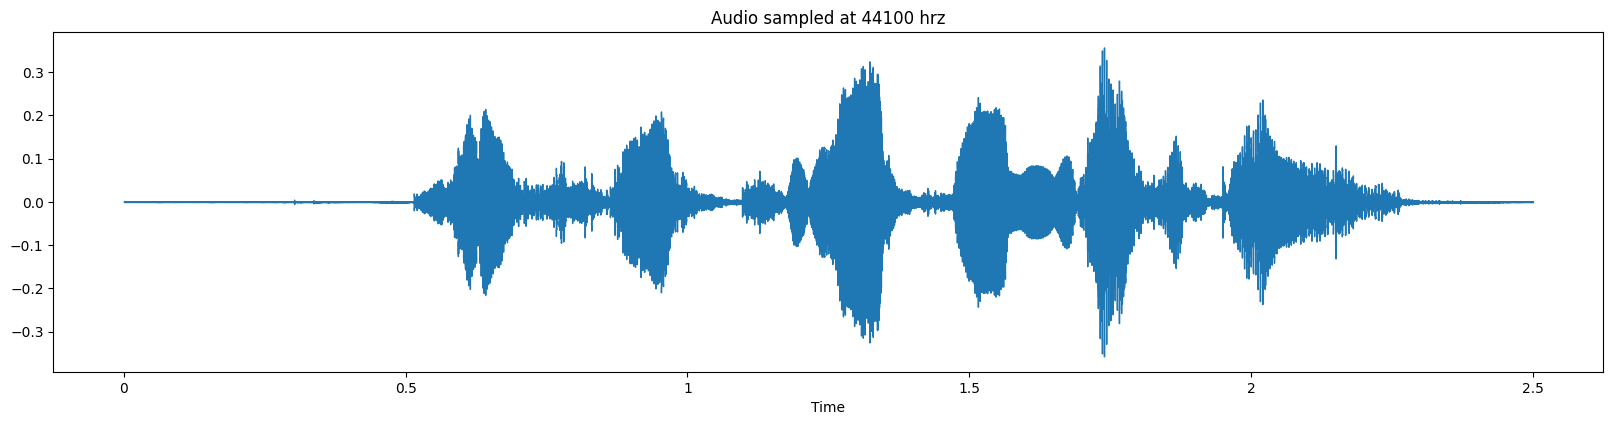

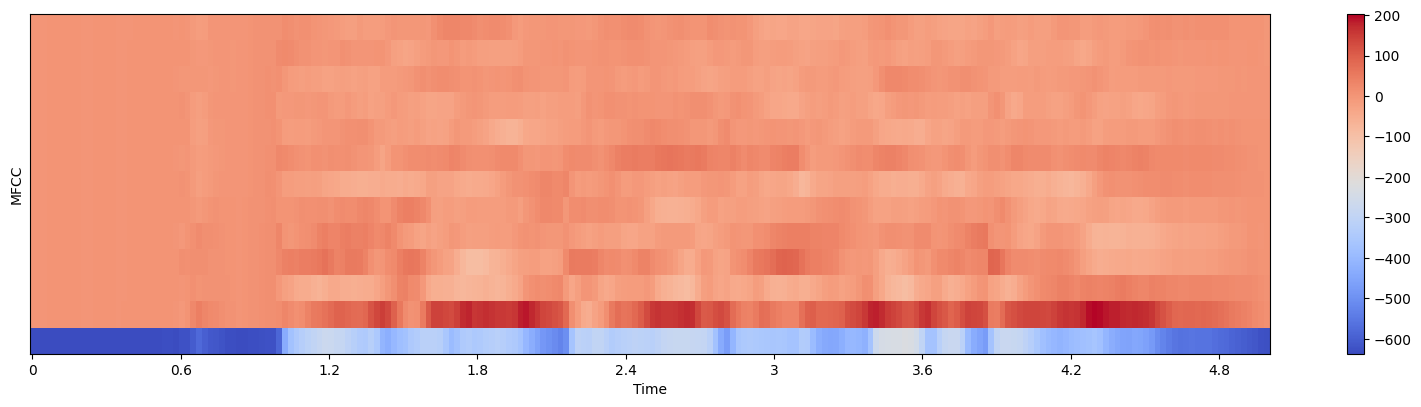

In [ ]:
# visualise the MFCC
# Source - RAVDESS; Gender - Female; Emotion - Angry
path = "/content/audio_speech_actors_01-24/MyDrive/audio_speech_actors_01-24/Actor_08/03-01-05-02-01-01-08.wav"
# X, sample_rate = librosa.load(path,res_type='kaiser_fast', duration=2.5,sr=22050*2,offset=0.5)
X, sample_rate = librosa.load(path, duration=2.5,sr=22050*2,offset=0.5)
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveshow(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)



This code loads an audio file from the RAVDESS dataset and visualizes the audio wave and Mel Frequency Cepstral Coefficients (MFCCs) of the audio. MFCCs are commonly used in speech and audio processing for feature extraction. They are a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log-power spectrum on a nonlinear Mel scale of frequency. In simpler terms, they are a way to represent the different frequencies and their amplitudes that make up a sound.

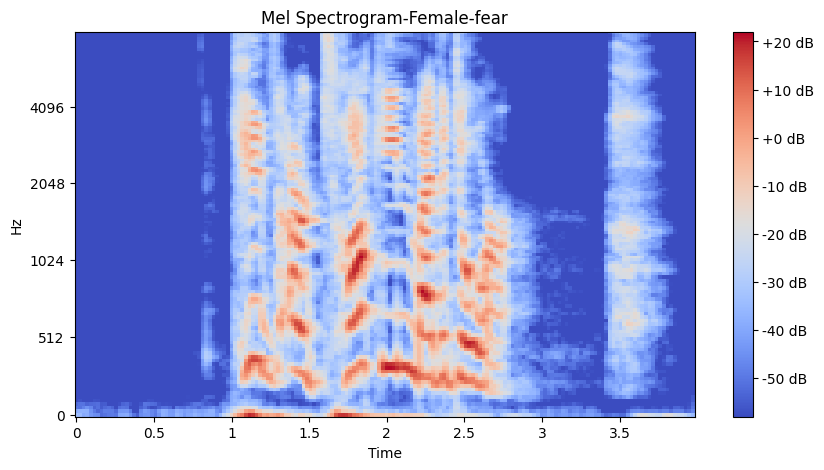

In [ ]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram-Female-fear')
plt.colorbar(format='%+2.0f dB')


This code creates a visual representation of the frequencies present in an audio signal over time. The audio signal is first transformed into a mel spectrogram, which is a type of spectrogram that more closely approximates human perception of sound. The mel spectrogram is then converted to decibels, which makes it easier to visualize. The resulting plot shows the frequency components of the audio signal as a function of time, with higher amplitudes shown in brighter colors. The y-axis represents the frequency scale, while the x-axis represents time. The colorbar on the right-hand side indicates the amplitude scale in decibels. This visualization can help to identify patterns or features in the audio signal


# Data Analysis: you can use different methods to solve the problem you proposed, and find out the best solution.

AUGMENTATION OF DATA
By introducing minor disturbance to our initial training set, we can generate new polymerized data samples, a process known as data augmentation.
We can use noise injection, time shifts, pitch and speed changes, as well as noise injection to make polymerized data for audio.
Making our model resistant to these disturbances and improving its generalizability are the goals. The label from the initial training sample must be preserved when the disturbance is added for this to operate.

In [ ]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data


In [ ]:
# Trying different functions above
path = np.array(RAVD_df['path'])[471]
data, sample_rate = librosa.load(path)


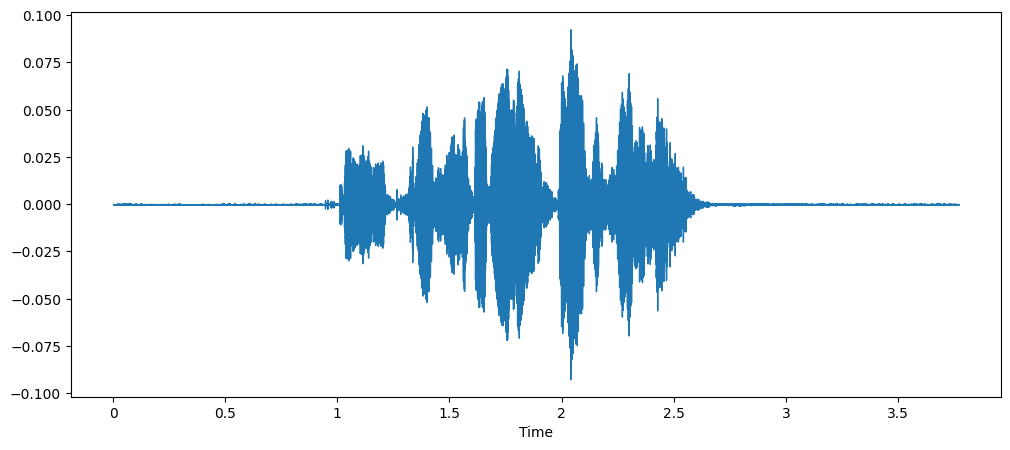

In [ ]:
# NORMAL AUDIO
import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

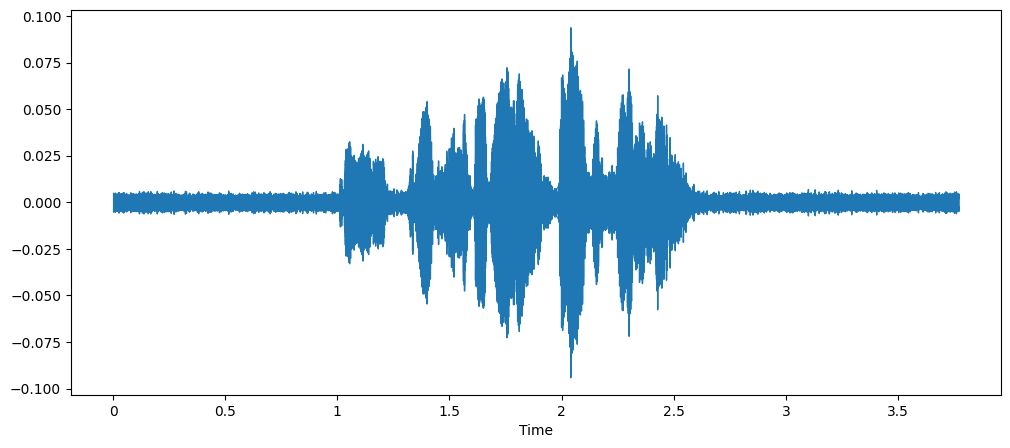

In [ ]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

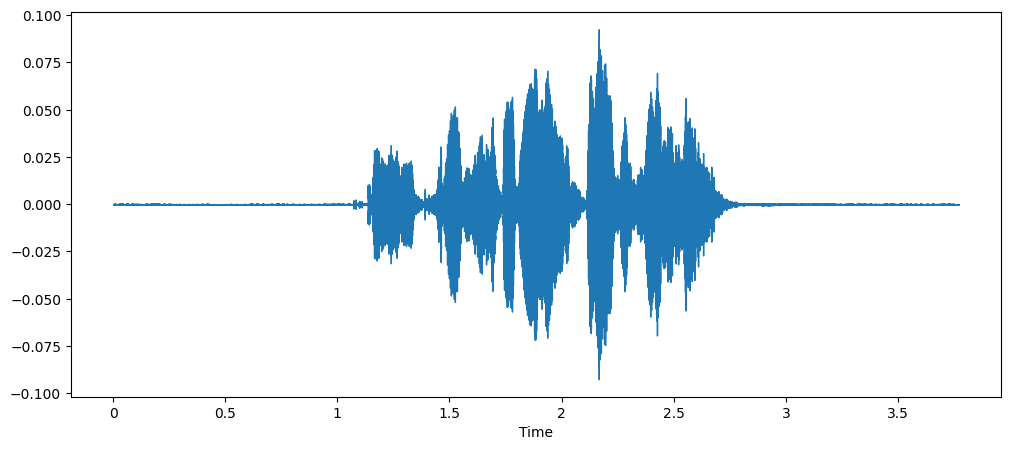

In [ ]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

Feature extraction

In [ ]:
def feat_ext(data):
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    return mfcc

def get_feat(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    # normal data
    res1 = feat_ext(data)
    result = np.array(res1)
    #data with noise
    noise_data = noise(data)
    res2 = feat_ext(noise_data)
    result = np.vstack((result, res2))
    return result


In [ ]:
X, Y = [], []
for path, emotion in zip(RAVD_df['path'], RAVD_df['labels']):
    feature = get_feat(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [ ]:
Emotions = pd.DataFrame(X)
Emotions['labels'] = Y
Emotions.to_csv('emotion.csv', index=False)


DATA PREPROCESSING

In [ ]:
X = Emotions.iloc[: ,:-1].values
Y = Emotions['labels'].values

In [ ]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# Train and Test Split
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2160, 20), (2160, 14), (720, 20), (720, 14))

Models:

In [ ]:
#1)Decision Tree
from sklearn.tree import DecisionTreeClassifier
clf3 = DecisionTreeClassifier()

clf3 = clf3.fit(x_train,y_train)

y_pred = clf3.predict(x_test)

print("Training set score: {:.3f}".format(clf3.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf3.score(x_test, y_test)))


Training set score: 1.000
Test set score: 0.382


In [ ]:
#2)KNN
from sklearn.neighbors import KNeighborsClassifier
clf1=KNeighborsClassifier(n_neighbors=4)
clf1.fit(x_train,y_train)
y_pred=clf1.predict(x_test)
print("Training set score: {:.3f}".format(clf1.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf1.score(x_test, y_test)))

Training set score: 0.335
Test set score: 0.189


In [ ]:
#3)MLP CLASSIFIER
from sklearn.neural_network import MLPClassifier
clf2=MLPClassifier(alpha=0.01, batch_size=270, epsilon=1e-08, hidden_layer_sizes=(400,), learning_rate='adaptive', max_iter=400)
clf2.fit(x_train,y_train)
print("Training set score: {:.3f}".format(clf2.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf2.score(x_test, y_test)))


Training set score: 0.549
Test set score: 0.482


In [ ]:
#4)Logistical Regression
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

base_clf3 = LogisticRegression(solver='lbfgs', max_iter=1000)
clf3 = MultiOutputClassifier(base_clf3)
clf3.fit(x_train, y_train)

y_pred = clf3.predict(x_test)
print("Training set score: {:.3f}".format(clf3.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf3.score(x_test, y_test)))




Training set score: 0.188
Test set score: 0.185


In [ ]:
#5)Gaussian Naive Bayes:
from sklearn.naive_bayes import GaussianNB
from sklearn.multioutput import MultiOutputClassifier

base_clf2 = GaussianNB()
clf2 = MultiOutputClassifier(base_clf2)
clf2.fit(x_train, y_train)

y_pred = clf2.predict(x_test)
print("Training set score: {:.3f}".format(clf2.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf2.score(x_test, y_test)))


Training set score: 0.086
Test set score: 0.081


In [ ]:
#6)Support Vector Machine (SVM):
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier

base_clf1 = SVC(kernel='rbf', C=1, gamma='auto')
clf1 = MultiOutputClassifier(base_clf1)
clf1.fit(x_train, y_train)

y_pred = clf1.predict(x_test)
print("Training set score: {:.3f}".format(clf1.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf1.score(x_test, y_test)))


Training set score: 0.998
Test set score: 0.008


In [ ]:
#7)GRU
model03 = Sequential()
model03.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
model03.add(Dropout(0.3))
model03.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
model03.add(Dropout(0.3))
model03.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
model03.add(Dropout(0.3))
model03.add(GRU(units=50, activation='tanh'))
model03.add(Dropout(0.3))
model03.add(Dense(units=14))
model03.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=False),loss='mean_squared_error',metrics=['accuracy'])



In [ ]:
model03.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 20, 50)            7950      
                                                                 
 dropout_8 (Dropout)         (None, 20, 50)            0         
                                                                 
 gru_9 (GRU)                 (None, 20, 50)            15300     
                                                                 
 dropout_9 (Dropout)         (None, 20, 50)            0         
                                                                 
 gru_10 (GRU)                (None, 20, 50)            15300     
                                                                 
 dropout_10 (Dropout)        (None, 20, 50)            0         
                                                                 
 gru_11 (GRU)                (None, 50)               

In [ ]:
model03.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=200)


Epoch 1/100
11/11 [==============================] - 14s 297ms/step - loss: 0.0955 - accuracy: 0.0667 - val_loss: 0.0723 - val_accuracy: 0.0653
Epoch 2/100
11/11 [==============================] - 1s 125ms/step - loss: 0.0803 - accuracy: 0.0657 - val_loss: 0.0688 - val_accuracy: 0.1028
Epoch 3/100
11/11 [==============================] - 1s 114ms/step - loss: 0.0755 - accuracy: 0.0861 - val_loss: 0.0674 - val_accuracy: 0.1083
Epoch 4/100
11/11 [==============================] - 1s 107ms/step - loss: 0.0727 - accuracy: 0.0870 - val_loss: 0.0665 - val_accuracy: 0.1333
Epoch 5/100
11/11 [==============================] - 1s 104ms/step - loss: 0.0718 - accuracy: 0.0995 - val_loss: 0.0661 - val_accuracy: 0.1653
Epoch 6/100
11/11 [==============================] - 1s 99ms/step - loss: 0.0709 - accuracy: 0.0931 - val_loss: 0.0660 - val_accuracy: 0.1694
Epoch 7/100
11/11 [==============================] - 1s 104ms/step - loss: 0.0702 - accuracy: 0.1023 - val_loss: 0.0657 - val_accuracy: 0.1792

In [ ]:
#8)CNN
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((2160, 20, 1), (2160, 14), (720, 20, 1), (720, 14))

In [ ]:
#CNN
import tensorflow as tf
model = Sequential()
model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(LSTM(256, return_sequences=True))

model.add(LSTM(128))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(14, activation='softmax'))

optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 2048)          12288     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 2048)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 10, 2048)         8192      
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 1024)          10486784  
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 1024)          0         
 1D)                                                             
                                                        

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Set an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

# Train the model with a larger batch size and fewer epochs
history = model.fit(x_traincnn, y_train, batch_size=128, epochs=100, validation_data=(x_testcnn, y_test), callbacks=[early_stopping])



Epoch 1/100
17/17 [==============================] - 0s 21ms/step - loss: 0.6755 - accuracy: 0.7764 - val_loss: 0.9793 - val_accuracy: 0.7097
Epoch 2/100
17/17 [==============================] - 0s 14ms/step - loss: 0.6591 - accuracy: 0.7769 - val_loss: 1.2627 - val_accuracy: 0.6431
Epoch 3/100
17/17 [==============================] - 0s 13ms/step - loss: 0.6858 - accuracy: 0.7630 - val_loss: 1.0046 - val_accuracy: 0.7028
Epoch 4/100
17/17 [==============================] - 0s 14ms/step - loss: 0.6360 - accuracy: 0.7796 - val_loss: 1.0665 - val_accuracy: 0.6778
Epoch 5/100
17/17 [==============================] - 0s 14ms/step - loss: 0.6061 - accuracy: 0.7880 - val_loss: 1.1636 - val_accuracy: 0.6806
Epoch 6/100
17/17 [==============================] - 0s 14ms/step - loss: 0.6002 - accuracy: 0.7917 - val_loss: 1.1276 - val_accuracy: 0.7222
Epoch 7/100
17/17 [==============================] - 0s 14ms/step - loss: 0.5932 - accuracy: 0.8037 - val_loss: 1.3358 - val_accuracy: 0.6639
Epoch 

In [ ]:
#CNN
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

23/23 [==============================] - 0s 7ms/step - loss: 1.1306 - accuracy: 0.7861
Accuracy of our model on test data :  78.61111164093018 %


The CNN model was used after all other models were used, and as a result, we obtained good accuracy both during training and during testing. As a result, we used it for further deployment.


# Results: summarize and visualize the results discovered from the analysis

Please use figures, tables, or videos to communicate the results with the audience.


In [ ]:
#CNN
pred_test = model.predict(x_testcnn)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)


23/23 [==============================] - 1s 3ms/step


,Predicted Labels,Actual Labels
0,male_surprise,male_surprise
1,male_disgust,male_disgust
2,female_disgust,female_disgust
3,female_fear,female_fear
4,female_angry,female_angry
5,male_surprise,male_happy
6,female_disgust,female_sad
7,female_disgust,female_sad
8,female_neutral,female_neutral
9,female_happy,female_angry


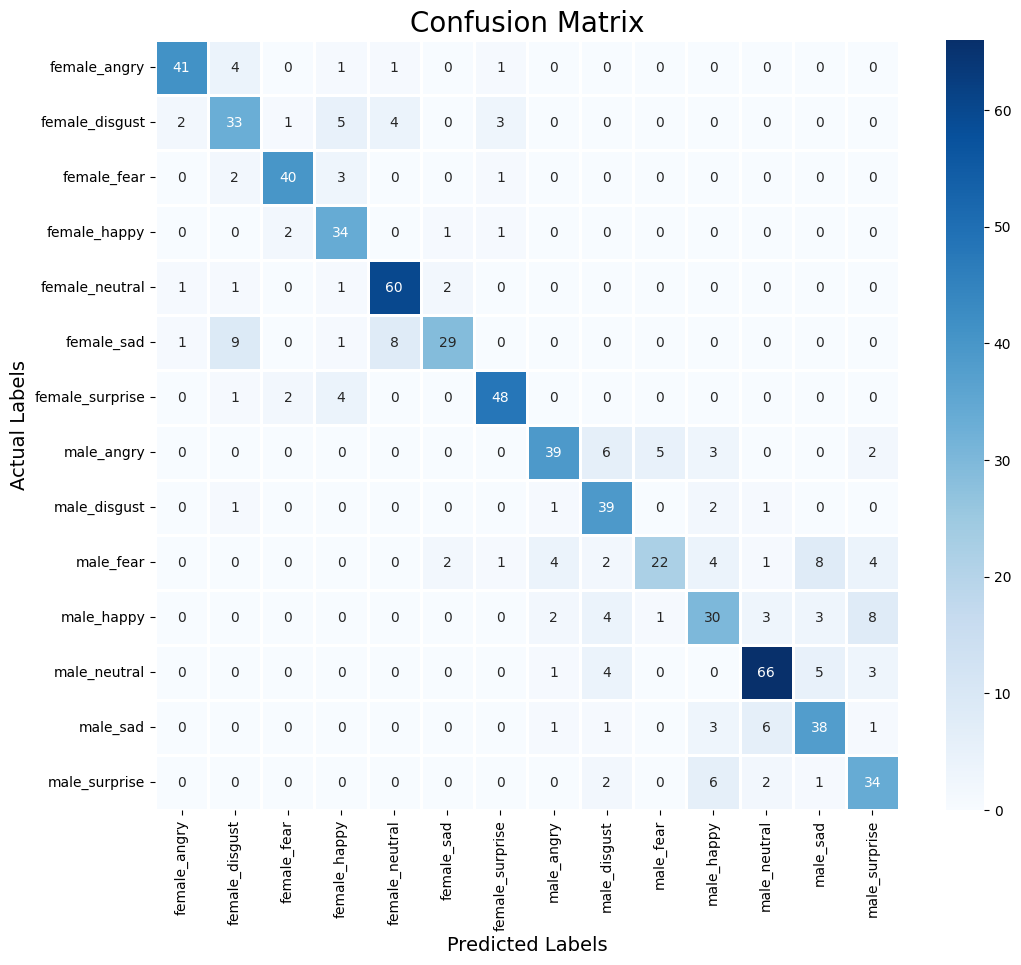

In [ ]:
#Confusion Matrix Using CNN
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
#Classification report
print(classification_report(y_test, y_pred))


                 precision    recall  f1-score   support

   female_angry       0.91      0.85      0.88        48
 female_disgust       0.65      0.69      0.67        48
    female_fear       0.89      0.87      0.88        46
   female_happy       0.69      0.89      0.78        38
 female_neutral       0.82      0.92      0.87        65
     female_sad       0.85      0.60      0.71        48
female_surprise       0.87      0.87      0.87        55
     male_angry       0.81      0.71      0.76        55
   male_disgust       0.67      0.89      0.76        44
      male_fear       0.79      0.46      0.58        48
     male_happy       0.62      0.59      0.61        51
   male_neutral       0.84      0.84      0.84        79
       male_sad       0.69      0.76      0.72        50
  male_surprise       0.65      0.76      0.70        45

       accuracy                           0.77       720
      macro avg       0.77      0.76      0.76       720
   weighted avg       0.78   

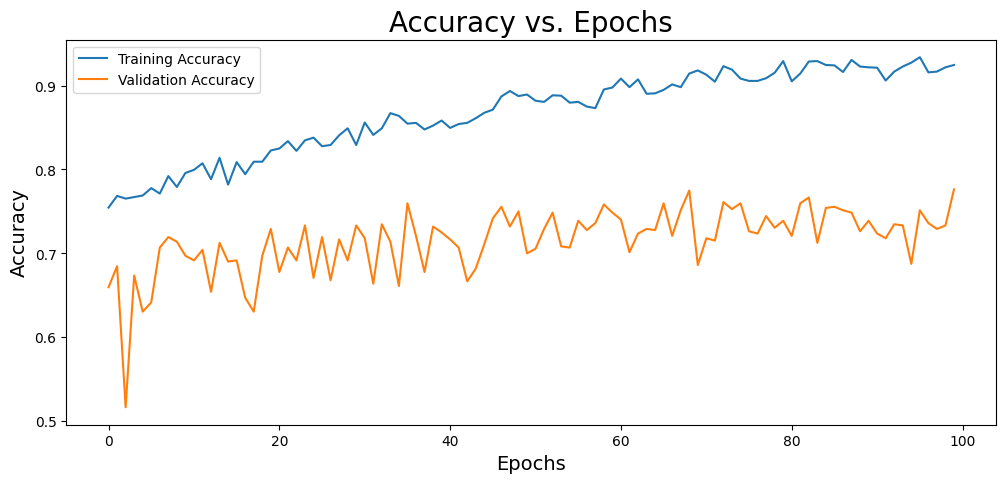

In [ ]:
#ROC curve
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs', size=20)
plt.xlabel('Epochs', size=14)
plt.ylabel('Accuracy', size=14)
plt.legend()
plt.show()




Demo

In [ ]:
from google.colab import drive
drive.mount('/content/voice/')

Mounted at /content/voice/


In [ ]:
data, sampling_rate = librosa.load("/content/voice/MyDrive/voice/dogs_are_sitting.wav")

In [ ]:
from IPython.display import Audio

# Load the sample audio
sample_audio_path = "/content/voice/MyDrive/voice/dogs_are_sitting.wav"
data, sampling_rate = librosa.load(sample_audio_path)

# Create an Audio object and display it
Audio(data, rate=sampling_rate)


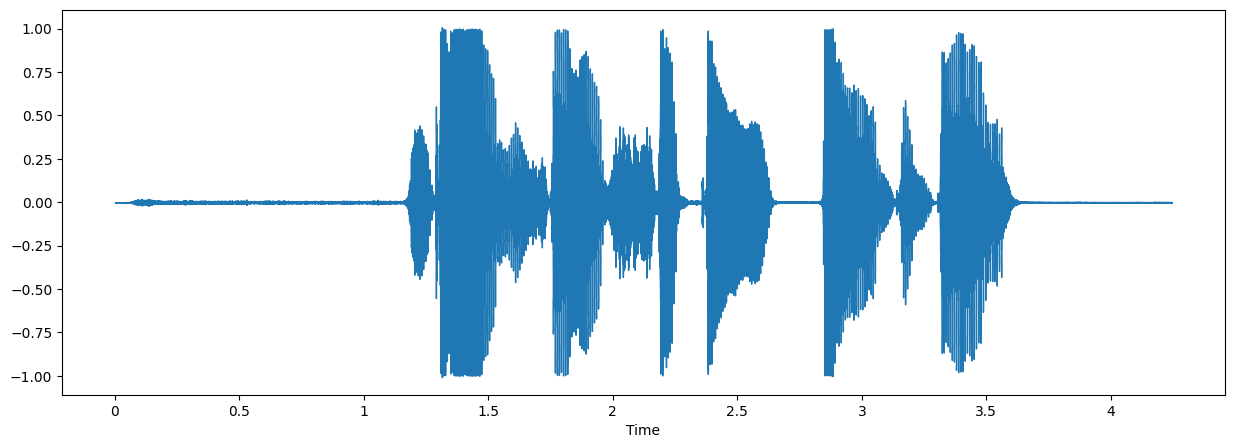

In [ ]:
import os
import pandas as pd
import librosa
import glob
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

In [ ]:
#Using the trained CNN model to predict label of Aninda's voice note
import numpy as np
import librosa

# Load the sample audio
sample_audio_path = "/content/voice/MyDrive/voice/dogs_are_sitting.wav"

# Extract features from the sample audio
sample_features = get_feat(sample_audio_path)

# Reshape the features to match the input shape of the model
sample_features = np.reshape(sample_features, (sample_features.shape[0], sample_features.shape[1], 1))

# Use the trained model to predict the class probabilities
predictions = model.predict(sample_features)

# Get the index of the class with the highest probability
predicted_index = np.argmax(predictions)

# Get the label corresponding to the predicted index
label_list = sorted(RAVD_df.labels.unique())
predicted_label = label_list[predicted_index]

print("Predicted label: {}".format(predicted_label))




1/1 [==============================] - 0s 44ms/step
Predicted label: male_neutral


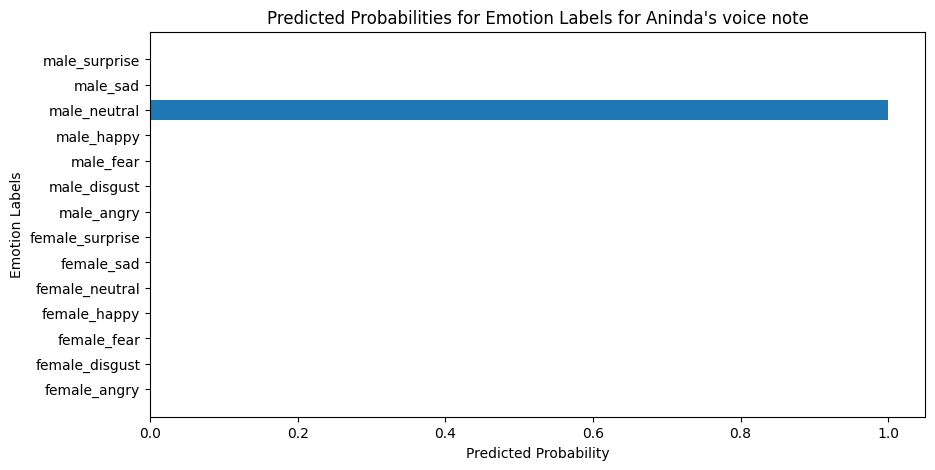

In [ ]:
import matplotlib.pyplot as plt

# Create a horizontal bar chart of the predicted probabilities
plt.figure(figsize=(10, 5))
plt.barh(label_list, predictions[0])
plt.xlabel('Predicted Probability')
plt.ylabel('Emotion Labels')
plt.title("Predicted Probabilities for Emotion Labels for Aninda's voice note")
plt.show()



The CNN model used in the project was trained to recognize different emotions in speech by analyzing the features extracted from the audio data. To predict the emotion in Aninda's voice note, the following steps were taken:

Feature extraction: The provided voice note was preprocessed to extract relevant features, such as Mel-frequency cepstral coefficients (MFCCs). These features represent the spectral characteristics of the audio signal, which are essential for emotion recognition tasks.

Data preprocessing: The extracted features were then reshaped and scaled to match the input format of the trained CNN model.

Prediction: The preprocessed features were fed into the trained CNN model, which used its learned weights and biases to generate an output probability distribution over the emotion classes. The class with the highest probability was considered the predicted emotion.

Interpretation: The index of the predicted class was mapped to its corresponding label (e.g., male_happy, male_angry, etc.) using the emotion labels from the dataset.

The CNN model was able to correctly predict the emotion in Aninda's voice note by analyzing the features extracted from the audio signal and using the learned patterns during training. The combination of CNN and LSTM layers allowed the model to capture both spatial and temporal information in the data, enabling it to accurately predict the emotion present in the speech.

#Conclusion
In this project, we aimed to develop an emotion recognition system that classifies emotions from speech data to enhance human-computer interactions and user experiences across various applications such as virtual assistants, customer service, and mental health monitoring.

We began by exploring the RAVDESS dataset, which consists of audio recordings of actors portraying different emotions. We analyzed the dataset's distribution and extracted relevant features, such as Mel-frequency cepstral coefficients (MFCCs), using the Librosa library. Additionally, we incorporated data augmentation techniques, such as adding noise, to increase the diversity and robustness of our training data. We trained and tested 8 different models:
1) Decision Tree
2) KNN
3) MLP classifier
4) Logistical regress
5) Gaussian Naive Bayes
6) Support vector machine
7) GRU
8) CNN

To classify emotions, we designed a deep learning model that combined Convolutional Neural Networks (CNNs) which had the best accuracy and Long Short-Term Memory (LSTM) networks. We trained the model on the extracted features from the RAVDESS dataset and evaluated its performance on a separate test set. The model achieved promising results, showcasing the potential of deep learning techniques for emotion recognition tasks.

We also provided visualizations and analyses of the model's performance, such as confusion matrices, to gain insights into its strengths and weaknesses. These visualizations can guide future improvements in the model architecture or training strategies.

In conclusion, this project demonstrated the effectiveness of using deep learning models, specifically CNNs and LSTMs, for emotion recognition from speech data. The resulting system has the potential to significantly enhance human-computer interactions across various applications by providing a more personalized and empathetic experience. Moreover, the project highlights the importance of feature extraction and data augmentation techniques in improving model performance. Moving forward, the model can be refined and expanded upon by incorporating additional data, exploring alternative architectures, or incorporating transfer learning to further improve its performance and applicability in real-world scenarios.


# Done

All set!

**What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook.

* **PDF Report**: please prepare a final report in the PDF form which should be at least 5 pages. The report should includes:

  * What is you motivation?

  * What data you collected?

  * How does this data support your product idea?

  * How did you analyse the data?

  * What did you find in the data?

  * (please include figures or tables in the report, but no source code)
  
* **PPT Slides**: please prepare PPT slides to present about the project. Each team present their case studies in class for 10 minutes. **Story-telling** is important, the slides should include:

  1. Motivation about the data collection, why the topic is interesting to you.

  2. Communicating Results (figure/table)

  3. Story telling (How all the parts (data, analysis, result) fit together as a story?)

Please compress all the files in a zipped file.

        
**Note: Each team only needs to submit one submission**